In [1]:
import os
import cv2

vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0331_091926_007.MP4" 
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
zfill_ = 5

EXTRACT_FRAMES = True
if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True)
    video = cv2.VideoCapture(f"{vid_path}{vid_filename}")
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

import pims
import trackpy as tp

# 1. Paths and Read-In

In [3]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0331_091926_007.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))  # before only used the green channel! now things look different in the locate function
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0331_091926_007/*.jpg
    Length: 2743 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

In [4]:
time = np.linspace(0, len(frames) / 60, len(frames))
tmax = len(frames)
# tpoint1 = np.where(time <= 23)[0][-1] 
# print("tpoints 1 frames=", tpoint1)
tpoint2 = np.where(time >= 24)[0][0]
print("tpoints 2 frames=", tmax - tpoint2)

tpoints 2 frames= 1303


In [5]:
show_frames = np.arange(tpoint2, tmax)

CALC_ZPROJ = True
if CALC_ZPROJ:
    zproj = []
    for n in show_frames:
        print(f"{n} / {show_frames}")
        zproj.append(frames[n].__array__() - frames[show_frames[0]].__array__())
    
    #zproj_ = np.max(np.stack(zproj), axis=0)
    zproj_min = np.min(np.stack(zproj), axis=0)
    del zproj

1440 / [1440 1441 1442 ... 2740 2741 2742]
1441 / [1440 1441 1442 ... 2740 2741 2742]
1442 / [1440 1441 1442 ... 2740 2741 2742]
1443 / [1440 1441 1442 ... 2740 2741 2742]
1444 / [1440 1441 1442 ... 2740 2741 2742]
1445 / [1440 1441 1442 ... 2740 2741 2742]
1446 / [1440 1441 1442 ... 2740 2741 2742]
1447 / [1440 1441 1442 ... 2740 2741 2742]
1448 / [1440 1441 1442 ... 2740 2741 2742]
1449 / [1440 1441 1442 ... 2740 2741 2742]
1450 / [1440 1441 1442 ... 2740 2741 2742]
1451 / [1440 1441 1442 ... 2740 2741 2742]
1452 / [1440 1441 1442 ... 2740 2741 2742]
1453 / [1440 1441 1442 ... 2740 2741 2742]
1454 / [1440 1441 1442 ... 2740 2741 2742]
1455 / [1440 1441 1442 ... 2740 2741 2742]
1456 / [1440 1441 1442 ... 2740 2741 2742]
1457 / [1440 1441 1442 ... 2740 2741 2742]
1458 / [1440 1441 1442 ... 2740 2741 2742]
1459 / [1440 1441 1442 ... 2740 2741 2742]
1460 / [1440 1441 1442 ... 2740 2741 2742]
1461 / [1440 1441 1442 ... 2740 2741 2742]
1462 / [1440 1441 1442 ... 2740 2741 2742]
1463 / [144

In [6]:
SAVE_NPY = True
if SAVE_NPY:
    np.save("./data/results/vortex/2024_0331_091926_007_zmin-proj-tpoint2.npy", zproj_min)
else:
    zproj_min = np.load("./data/results/vortex/2024_0331_091926_007_zmin-proj-tpoint2.npy")

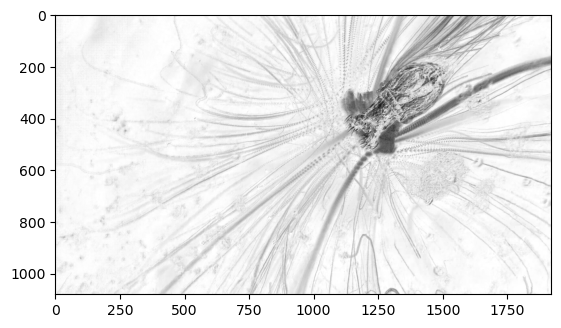

In [7]:
plt.figure()
plt.imshow(zproj_min, cmap="gray")  # show_frames = np.arange(tpoint2, tmax)
plt.savefig("./data/results/vortex/2024_0331_091926_007_zmin-proj.jpg", dpi=600)

## Locate features for single frame

In [ ]:
# 60fps
diameter = 13
threshold = 15
percentile = 80
frame_nr = 0

# Location of features
f = tp.locate(frames[frame_nr], diameter, invert=True, threshold=threshold)  #, percentile=percentile)

plt.figure(figsize=(6,6))
tp.annotate(f, frames[frame_nr]);  # this shows the bandpass filtered image

print(len(f))
f.head(5)

# 2. Batch Process frames

In [ ]:
tp.quiet()
f = tp.batch(frames[tpoint2:], diameter, invert=True, threshold=threshold)

### Plot some of the parameters of detected particels

In [ ]:
params = ["mass", "size", "ecc", "signal", "raw_mass", "ep"]

fig, ax = plt.subplots(1, 6, figsize=(19,2.5))
for nth, param in enumerate(params):
    ax[nth].hist(f[param], bins=100)
    ax[nth].set(xlabel=param, ylabel='count');

### filter frames based on coordinates

In [ ]:
#f2 = f[(f["x"] > 500)]
#print(len(f), len(f2))

# 3. Link particles / frames to trajectories

In [ ]:
tp.quiet()
max_displacement = 55  # in px
particle_memory = 5
t = tp.link(f, max_displacement, memory=particle_memory, adaptive_stop=10, adaptive_step=.95)
t.head()

# 4. Filter trajectories

In [ ]:
lasts_num_frames = 30
t1 = tp.filter_stubs(t, lasts_num_frames)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
# t1.to_csv("./data/results/vortex/traj1.csv")

In [ ]:
# trajs
ctraj = t1
frame_nr = tpoint2
particles = ctraj.particle.unique()

print("number of particles = number of trajectories:", len(particles))

stats = dict()
frames_present = []

for nth, prt in enumerate(particles):
    sub = ctraj[ctraj.particle == prt]
    
    if not sub.empty:
        x, y = sub.x, sub.y
        dx, dy = x.diff(), y.diff()
        
        stats[int(prt)] = {
        "particle" : prt,
        "x_avg" : x.mean(),
        "y_avg" : y.mean(),
        "x_std" : x.std(),
        "y_std" : y.std(),
        "travel_dist" : sum(np.sqrt(dx[1:] ** 2 + dy[1:] ** 2)),
        "frames_present" : sub["frame"].to_list(), 
        "first_frame" : sub["frame"].min(),
        "last_frame" : sub["frame"].max(),
        "nframes" : len(sub["frame"].unique()),
        "ep_mean" : sub["ep"].mean(),
        "ep_median" : sub["ep"].median(),
        "displacement_first_last" : np.sqrt((x.to_list()[-1] - x.to_list()[0]) ** 2 + (y.to_list()[-1] - y.to_list()[0]) ** 2)
    }
        frames_present.extend(sub["frame"].to_numpy())

frames_present = np.array(frames_present)
stats = pd.DataFrame.from_dict(stats, orient="index")
stats.head(5)

# More filtering trajectories

In [ ]:
reject_idx = (stats.x_std < 15) & (stats.y_std < 15) & (stats.displacement_first_last < 40)
reject_prts = stats.particle[reject_idx].to_numpy()
reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(ctraj["particle"] == rprt)[0])

reject_traj_idx = np.concatenate(reject_traj_idx)
reject_traj_idx
#ctraj.iloc[reject_traj_idx,:].drop()
ctraj2 = ctraj.reset_index(drop=True)
ctraj3 = ctraj2.drop(reject_traj_idx)#ctraj2.iloc[reject_traj_idx,:] #ctraj2.drop(reject_traj_idx)
ctraj3

particles = ctraj3.particle.unique()

print("number of particles = number of trajectories:", len(particles))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
tp.scatter(ctraj3, ax=ax[0], plot_style={"ms" : 2, "alpha" : .1, "color" : "k"})
tp.plot_traj(ctraj3, superimpose=frames[frame_nr], ax=ax[1], plot_style={"lw" : .5});
tp.plot_traj(ctraj3, superimpose=frames[frame_nr], ax=ax[2], plot_style={"color": "k", "lw" : 1, "alpha" : .3});

### trajectory params

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
tp.mass_size(ctraj.groupby("particle").mean(), ax=ax[0]);
tp.mass_ecc(ctraj.groupby("particle").mean(), ax=ax[1]);

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");
# plt.figure()
# plt.hist(stats.displacement_first_last, bins=100);
# stats.displacement_first_last.sort_values()[:30];

## Inspect all trajectories

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
tp.scatter(ctraj, ax=ax[0], plot_style={"ms" : 2, "alpha" : .1, "color" : "k"})
tp.plot_traj(ctraj, superimpose=frames[frame_nr], ax=ax[1], plot_style={"lw" : .5});
tp.plot_traj(ctraj, superimpose=frames[frame_nr], ax=ax[2], plot_style={"color": "k", "lw" : 1, "alpha" : .3});

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"})
ax.set_xlim(1000, 1400); ax.set_ylim(0, 400)
ax.invert_yaxis()

## Max/Min Z projection of all Frames

In [ ]:
x_line = [1320, 730]
y_line = [0, 1050]

plt.imshow(zproj_min, cmap="gray")  # show_frames = np.arange(tpoint2, tmax)
plt.plot(x_line, y_line, "-r", alpha=.8)

x_line = [700, 1800]
y_line = [0, 680]
plt.plot(x_line, y_line, "-r", alpha=.8)
plt.xlim(500, 1800);
#plt.gca().invert_yaxis()

- select two to three trajectories (color coded velocity) to illustrate and take a range of images around that for the min-projection
- select maybe through a histogram of frame counts to delineate wehere most particles were detected
- try to find those that go into the mouth, and one that is discarded from the mouth
- draw small arrows to visualize direction?

## Single trajectory and Max/Min Z projection of Frames

In [ ]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")

for prt in selected_prts:
    traj = ctraj.loc[ctraj["particle"] == prt] # 7,16
    prt_frames = traj["frame"].unique()
    x = traj.x.to_numpy()
    y = traj.y.to_numpy()
    
    ax.plot(x, y, "-k", lw=.5)
    ax.plot(x[::20], y[::20], "ok", mfc="w")
    ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
    ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800);

In [ ]:
# have to do this with arrows, < and > do not cover it
traj = ctraj.loc[ctraj["particle"] == 354] # 7,16,9
prt_frames = traj["frame"].unique()
x = traj.x.to_numpy()
y = traj.y.to_numpy()

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")
ax.plot(x, y, "-k", lw=.5)
ax.plot(x[::20], y[::20], "ok", mfc="w")
ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800); #ax.set_ylim(0, 700)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
tp.plot_traj(traj, superimpose=frames[frame_nr], ax=ax)
ax.plot(x, y, "--k")
ax.plot(x[0], y[0], ".r", label="start")
ax.plot(x[len(traj)-1], y[len(traj)-1], ".b", label="end")
ax.set_xlim(850, 1800); ax.set_ylim(0, 1000)
ax.legend()

### Position change
- loop through the points to color frames by velocity or global frame nr


In [ ]:
dx = traj.x.diff()
dy = traj.y.diff()
dist = np.sqrt(dx ** 2 + dy ** 2)

fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(dx, "-b", label="dx")
plt.plot(-dy, "-r", label="dy")
plt.plot(dist, "-k", label="dist")
plt.legend()

In [ ]:
indices = stats.travel_dist.sort_values(ascending=False)[:20].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())

ccmap = mpl.cm.brg
yxlim = frames[0].shape
part_idx = selected_prts
colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(part_idx))]

fig, ax = plt.subplots(figsize=(10,4))
for nth, pt in enumerate(part_idx):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        #tp.plot_traj(traj, ax=ax, plot_style={"color": colors[nth]}, label=True);  # display {"linecolor": "k"}
        tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
xy = ctraj.loc[ctraj["particle"] == 354, ["x", "y"]]
xy2 = ctraj.loc[ctraj["particle"] == 7, ["x", "y"]]

plt.figure(figsize=(4,3))
plt.plot(xy["x"], xy["y"], "-ok", lw=2, mfc="w", ms=3, label="354")
plt.plot(xy2["x"], xy2["y"], "-or", lw=2, mfc="w", ms=3, label="7")
plt.legend()
plt.gca().invert_yaxis()

plt.figure(figsize=(25,25))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True); # , label=True, colorby="frame", plot_style={"set_xlim" : [1400, 1550]}

In [ ]:

cmap = plt.cm.jet
part_idx = [9,7,354] # sorted([24,861, 646, 899, 207, 13,38,702, 578, 738, 912])
fig, ax = plt.subplots(figsize=(10,4))
#ax.set_facecolor('black')

for nth, pt in enumerate(part_idx):  # 13, 646, 912
    traj = ctraj.loc[ctraj["particle"] == pt]
    
    if not traj.empty:
        x, y = traj.x.to_numpy(), traj.y.to_numpy()
        dx, dy = traj.x.diff(), traj.y.diff()
        
        dist = np.sqrt(dx ** 2 + dy ** 2)
        vector = dist.to_numpy()[1:]
        norm = plt.Normalize(vector.min(), vector.max())
        
        # Create a LineCollection from the data
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "ok", mfc="k", label="start")
        ax.plot(x[len(traj)-1], y[len(traj)-1], "o", mec="gray", mfc="gray", label="end")

ax.plot(1000, 100, "sm", mfc="m", ms=10, label="corona")


In [ ]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots()

for nth in list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        #norm = plt.Normalize(vector.min(), vector.max())
        norm = plt.Normalize(0, 45)
        # Create a LineCollection from the data
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

In [ ]:
minmax_ = np.array(minmax)
minmax_.shape
print(minmax_.min(), minmax_.max())

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
tp.plot_displacements(ctraj, 1800, 1810, ax=ax);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
# VELOCITY FIELD FOR LATER 
# i = 0
# d = data[data.frame==i]
# plt.imshow(rawframes[i])
# plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
# plt.axis('off')